In [1]:
from itertools import combinations, permutations
from math import factorial, ceil, floor

# permutations does not scale well and we can exploit the fact that the order of the 4 queens does not matter (hence combinations)
# then we just have to pick all remaining squares for the bishop
# return permutations(range(0, 64), 5) 
# order actually matters (at least for the 4 first) 
# return combinations(list(range(0, 64)), 5) 
# iterator-based implem
def gen_combinations_basic():
    # 4 queens (order does not matter) + 1 bishop
    for c in combinations(range(0, 64), 4):
        for i in [elem for elem in list(range(0, 64)) if not elem in list(c)]:
            yield(c + (i,))
# assert(len(list(gen_combinations())) == (factorial(64) / (factorial(64 - 5) * factorial(5))))
# assert(len(list(gen_combinations())) == (factorial(64) / (factorial(64 - 5))))
# combinations of 4 among 64, and then 60 remaining possibilities
assert(len(list(gen_combinations_basic())) == (factorial(64) / (factorial(64 - 4) * factorial(4))) * 60)

# iterator
# we can exploit the property of the problem: first queen on square 0..32 (symmetry then)
def gen_combinations_tuned():
    for q1 in range(0, 32):
        for qs in [queens for queens in combinations(range(0, 64), 3) if not q1 in list(queens)]:
            for b in [elem for elem in list(range(0, 64)) if not elem in list(qs) and not elem == q1]:
                yield (q1,) + qs + (b,)
# len(list(gen_combinations_tuned()))

def gen_combinations(tuned=False):
    if tuned:
        return gen_combinations_tuned()
    else:
        return gen_combinations_basic()
        
        

In [2]:
(factorial(64) / (factorial(64 - 4) * factorial(4))) * 60

38122560.0

In [3]:
len(list(gen_combinations_basic())), len(list(gen_combinations_tuned()))

(38122560, 76245120)

In [97]:
def to_coordinates(q):
    # {\displaystyle a{\bmod {n}}=a-(\lfloor a/n\rfloor \times n)}.
    # https://www.chessprogramming.org/Efficient_Generation_of_Sliding_Piece_Attacks#Squares_and_Bitindex
    # x = q % 8
    # x = q - (floor(q / 8) * 8) 
    x = q & 7
    # y = floor(q / 8)
    y = q >> 3   
    return (x, y)

assert(to_coordinates(63) == (7, 7))
assert(to_coordinates(28) == (4, 3))
assert(to_coordinates(1) == (1, 0))
assert(to_coordinates(0) == (0, 0))
assert(to_coordinates(7) == (7, 0))
assert(to_coordinates(56) == (0, 7))
assert(to_coordinates(8) == (0, 1))
assert(to_coordinates(9) == (1, 1))

def add_x(t, m): # a tuple
    x = t[0]
    y = t[1]
    return (x+m, y)

def add_y(t, m): # a tuple
    x = t[0]
    y = t[1]
    return (x, y+m)

assert(add_x(to_coordinates(0), 1) == (1, 0))
assert(add_y(to_coordinates(0), 1) == (0, 1))

In [5]:


# is reachable: no piece already in and not outside the chessboard
def is_casein_chessboard(t, board=()): # a tuple
    x = t[0]
    y = t[1]
    for p in board:
        xp = to_coordinates(p)[0]
        yp = to_coordinates(p)[1]
        if (xp == x and yp == y):
            return False
    return x >= 0 and x <= 7 and y >= 0 and y <= 7

def vertical_directions(q, board=()):
    def vertical_direction(q, north=True):
        norths = []
        qcase = to_coordinates(q)
        for i in range(1, 8):
            if north:
                possible_move = add_y(qcase, i)
            else:
                possible_move = add_y(qcase, -i)
            if (not is_casein_chessboard(possible_move, board)):
                break
            x = possible_move[0]
            y = possible_move[1]
            norths.append(x + y*8)
        return norths
    n = vertical_direction(q, True)
    s = vertical_direction(q, False)
    return n + s

def horizontal_directions(q, board=()):
    def horizontal_direction(q, east=True):
        eaths = []
        qcase = to_coordinates(q)
        for i in range(1, 8):
            if east:
                possible_move = add_x(qcase, i)
            else:
                possible_move = add_x(qcase, -i)
            if (not is_casein_chessboard(possible_move, board)):
                break
            x = possible_move[0]
            y = possible_move[1]
            eaths.append(x + y*8)
        return eaths

    w = horizontal_direction(q, True)
    e = horizontal_direction(q, False)
    return e + w



def diagup(q, board=()):
    def diagup_direction(q, east=True):
        eaths = []
        qcase = to_coordinates(q)
        for i in range(1, 8):
            if east:
                possible_move = add_y(qcase, i)
                possible_move = add_x(possible_move, i)
            else:
                possible_move = add_y(qcase, i)
                possible_move = add_x(possible_move, -i)
            if (not is_casein_chessboard(possible_move, board)): 
                break
            x = possible_move[0]
            y = possible_move[1]
            eaths.append(x + y*8)
        return eaths
    w = diagup_direction(q, True)
    e = diagup_direction(q, False)
    return e + w


def diagdown(q, board=()):
    def diagdown_direction(q, east=True):
        eaths = []
        qcase = to_coordinates(q)
        for i in range(1, 8):
            if east:
                possible_move = add_y(qcase, -i)
                possible_move = add_x(possible_move, i)
            else:
                possible_move = add_y(qcase, -i)
                possible_move = add_x(possible_move, -i)
            if (not is_casein_chessboard(possible_move, board)):
                break
            x = possible_move[0]
            y = possible_move[1]
            eaths.append(x + y*8)
        return eaths
    s = diagdown_direction(q, True)
    n = diagdown_direction(q, False)
    return s + n

def squares_covered_byqueen(q, board=()):
    horizontals = horizontal_directions(q, board)
    verticals = vertical_directions(q, board)
    diagsup = diagup(q, board)
    diagsdown = diagdown(q, board)
    
    return [q] + horizontals + verticals + diagsup + diagsdown

def squares_covered_bybishop(q, board=()):
    diagsup = diagup(q, board)
    diagsdown = diagdown(q, board)
    return [q] + diagsup + diagsdown

print("0", sorted(squares_covered_byqueen(0)))
print("1", squares_covered_byqueen(1))
print("63", squares_covered_byqueen(63))
print("13", squares_covered_byqueen(13))
print("28", squares_covered_byqueen(28))



assert(len(squares_covered_byqueen(0)) == (1+7+7+7))
assert(len(squares_covered_byqueen(63)) == (1+7+7+7))
assert(len(squares_covered_byqueen(1)) == (1+7+7+6+1))
assert(len(squares_covered_byqueen(28)) == (1+7+7+7+6))

assert(len(squares_covered_bybishop(28)) == (1+7+6))
assert(len(squares_covered_bybishop(0)) == (1+7))
# let's go metamorphic ;)
assert(len(squares_covered_bybishop(0)) == len(squares_covered_bybishop(63)))
assert(len(squares_covered_bybishop(56)) == len(squares_covered_bybishop(7)))
assert(len(squares_covered_bybishop(4)) == len(squares_covered_bybishop(60)))
assert(len(squares_covered_bybishop(1)) == len(squares_covered_bybishop(57)))

print("0 (with pieces between)", sorted(squares_covered_byqueen(0, board=[1])))
print("0 (with pieces between)", sorted(squares_covered_byqueen(0, board=[8])))
print("0 (with pieces between)", sorted(squares_covered_byqueen(0, board=[1, 8])))
print("0 (with pieces between)", sorted(squares_covered_byqueen(0, board=[1, 8, 9])))
print("0 (with pieces between)", sorted(squares_covered_byqueen(0, board=[1, 8, 54])))

assert(len(squares_covered_byqueen(0, board=[1])) == 1+7+7)
assert(len(squares_covered_byqueen(0, board=[8])) == 1+7+7)
assert(len(squares_covered_byqueen(0, board=[8, 1])) == 1+7)
assert(len(squares_covered_byqueen(0, board=[9, 8, 1])) == 1)
assert(len(squares_covered_byqueen(0, board=[9])) == 1+7+7)
assert(len(squares_covered_byqueen(0, board=[54])) == 1+7+7+5)

assert(len(squares_covered_bybishop(0, board=[54])) == 1+5)
assert(len(squares_covered_bybishop(9, board=[])) == 1+7+2)

assert(squares_covered_byqueen(0, board=[8, 9]) == [0, 1, 2, 3, 4, 5, 6, 7]) # we include here 0
assert(horizontal_directions(0) == [1, 2, 3, 4, 5, 6, 7])

# squares_covered_byqueen(0, board=[1, 2, 15, 44])
squares_covered_byqueen(0, board=[1, 9]), [8, 16, 24, 32, 40, 48, 56]


# print("1", squares_covered_byqueen(1))
#print("63", squares_covered_byqueen(63))
#print("13", squares_covered_byqueen(13))
#print("28", squares_covered_byqueen(28))


# horizontal_directions(0, board=[8, 9]), vertical_directions(0, board=[8, 9]), vertical_directions(0), horizontal_directions(0)
# diagup_direction(0), diagup_direction(7, False), diagup_direction(4, False), diagup_direction(4, True), diagup_direction(63, False)
# diagup(28), diagdown_direction(28), diagdown_direction(28, False)
# [mult_coordinates((0, 1), i) for i in range(0, 8)], [add_coordinates((0, 0), i*8) for i in range(0, 8)]

0 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 16, 18, 24, 27, 32, 36, 40, 45, 48, 54, 56, 63]
1 [1, 0, 2, 3, 4, 5, 6, 7, 9, 17, 25, 33, 41, 49, 57, 8, 10, 19, 28, 37, 46, 55]
63 [63, 62, 61, 60, 59, 58, 57, 56, 55, 47, 39, 31, 23, 15, 7, 54, 45, 36, 27, 18, 9, 0]
13 [13, 12, 11, 10, 9, 8, 14, 15, 21, 29, 37, 45, 53, 61, 5, 20, 27, 34, 41, 48, 22, 31, 6, 4]
28 [28, 27, 26, 25, 24, 29, 30, 31, 36, 44, 52, 60, 20, 12, 4, 35, 42, 49, 56, 37, 46, 55, 21, 14, 7, 19, 10, 1]
0 (with pieces between) [0, 8, 9, 16, 18, 24, 27, 32, 36, 40, 45, 48, 54, 56, 63]
0 (with pieces between) [0, 1, 2, 3, 4, 5, 6, 7, 9, 18, 27, 36, 45, 54, 63]
0 (with pieces between) [0, 9, 18, 27, 36, 45, 54, 63]
0 (with pieces between) [0]
0 (with pieces between) [0, 9, 18, 27, 36, 45]


([0, 8, 16, 24, 32, 40, 48, 56], [8, 16, 24, 32, 40, 48, 56])

In [6]:
# print("0 with bishop", sorted(squares_covered_byqueen(0, board=[16])))
print("0 with piece between", horizontal_directions(0, board=[1]))
print("0 with piece between", horizontal_directions(0, board=[2]))
print("0", horizontal_directions(0))
to_coordinates(1), to_coordinates(16)

0 with piece between []
0 with piece between [1]
0 [1, 2, 3, 4, 5, 6, 7]


((1, 0), (0, 2))

In [7]:
import chess
import chess.svg


# my own implementation (see above)
def nbcases_covered(cmb):
    squares = []
    for q in range(0, 4):
        squares = squares + squares_covered_byqueen(cmb[q], cmb) # TODO
    bishop_case = cmb[4]
    squares = squares + squares_covered_bybishop(bishop_case, cmb) # TODO
    for q in range(0, 5):
        squares.append(cmb[q])
    return len(set(squares))





In [8]:
# we reuse built-in facilities of python-chess for generating moves
def nbcases_covered_reuse(cmb):
    board = chess.Board() 
    board.clear_board()
    
    for q in range(0, 4):
        board.set_piece_at(cmb[q], chess.Piece(chess.QUEEN, color=True))
    board.set_piece_at(cmb[4], chess.Piece(chess.BISHOP, color=True))  
    
    squares = []
    for q in range(0, 5):
        squares.append(cmb[q])
        squares = squares + list(board.attacks(cmb[q]))
    # squares = set(squares + list(board.attacks(cmb[4])))
    return len(set(squares))


In [9]:



def compute_solutions(move_generation_reuse = True):
    recorded_solutions_percases = {}
    ntries = 0
    for cmb in gen_combinations():
        if move_generation_reuse:
            n = nbcases_covered_reuse(cmb)
        else:
            n = nbcases_covered(cmb)
        if not n in recorded_solutions_percases:
            nfreq = 1
        else:
            nfreq =  recorded_solutions_percases[n][0] + 1
        recorded_solutions_percases[n] = (nfreq, cmb)
        ntries = ntries + 1
        if (n > 63): # the solution(s)
            print(cmb, "=>", n, ntries)
        # if n <= 42: # sounds incredible
        if ntries == 10000000: # monitor a bit 
            print("alive!")
    #        print(cmb, "=>", n, ntries)
    return recorded_solutions_percases

from timeit import default_timer as timer

start = timer()
recorded_solutions = compute_solutions(True)
end = timer()
print("duration", end - start)

# start = timer()
# recorded_solutions_withoutreuse = compute_solutions(False)
# end = timer()
# print("duration without reuse", end - start)

recorded_solutions # , recorded_solutions_withoutreuse

(0, 6, 29, 51, 3) => 64 592623
(0, 12, 39, 57, 24) => 64 1116203
(0, 12, 39, 57, 42) => 64 1116220
(0, 12, 39, 57, 51) => 64 1116229
(0, 12, 44, 52, 15) => 64 1122194
(0, 12, 44, 52, 22) => 64 1122201
(0, 12, 44, 52, 29) => 64 1122208
(0, 12, 44, 52, 36) => 64 1122215
(0, 12, 44, 52, 57) => 64 1122234
(0, 15, 33, 60, 3) => 64 1318563
(0, 15, 33, 60, 21) => 64 1318580
(0, 15, 33, 60, 30) => 64 1318589
(0, 15, 35, 44, 25) => 64 1321044
(0, 15, 35, 44, 61) => 64 1321078
(0, 20, 28, 60, 15) => 64 1606275
(0, 20, 28, 60, 36) => 64 1606294
(0, 20, 28, 60, 43) => 64 1606301
(0, 20, 28, 60, 50) => 64 1606308
(0, 20, 28, 60, 57) => 64 1606315
(0, 20, 38, 50, 25) => 64 1623384
(0, 20, 38, 50, 43) => 64 1623401
(0, 20, 38, 50, 61) => 64 1623418
(0, 22, 34, 52, 11) => 64 1717991
(0, 22, 34, 52, 29) => 64 1718008
(0, 22, 34, 52, 47) => 64 1718025
(0, 28, 37, 43, 17) => 64 1969217
(0, 28, 37, 43, 26) => 64 1969226
(0, 28, 37, 43, 53) => 64 1969250
(0, 28, 37, 43, 62) => 64 1969259
(0, 28, 37, 57, 11

(11, 23, 33, 54, 7) => 64 21259568
(11, 23, 33, 54, 28) => 64 21259587
(11, 23, 33, 54, 42) => 64 21259600
(11, 23, 33, 54, 56) => 64 21259613
(11, 29, 41, 63, 16) => 64 21506116
(11, 29, 41, 63, 34) => 64 21506133
(11, 29, 41, 63, 52) => 64 21506150
(11, 30, 49, 61, 0) => 64 21546061
(11, 30, 49, 61, 18) => 64 21546078
(11, 30, 49, 61, 36) => 64 21546095
(11, 30, 49, 61, 63) => 64 21546120
(11, 31, 41, 61, 0) => 64 21567421
(11, 31, 41, 61, 18) => 64 21567438
(11, 31, 41, 61, 36) => 64 21567455
(11, 31, 41, 61, 54) => 64 21567472
(11, 31, 41, 61, 63) => 64 21567480
(11, 31, 45, 57, 34) => 64 21571893
(11, 37, 56, 62, 59) => 64 21721737
(12, 16, 38, 49, 0) => 64 22136761
(12, 16, 38, 49, 27) => 64 22136786
(12, 16, 38, 49, 45) => 64 22136803
(12, 16, 38, 49, 63) => 64 22136820
(12, 20, 52, 56, 1) => 64 22384322
(12, 20, 52, 56, 28) => 64 22384347
(12, 20, 52, 56, 37) => 64 22384356
(12, 20, 52, 56, 46) => 64 22384365
(12, 20, 52, 56, 55) => 64 22384373
(12, 24, 42, 62, 37) => 64 225675

{52: (2087140, (60, 61, 62, 63, 59)),
 53: (3294040, (60, 61, 62, 63, 57)),
 51: (1232544, (60, 61, 62, 63, 55)),
 47: (60440, (60, 61, 62, 63, 54)),
 48: (149164, (60, 61, 62, 63, 52)),
 55: (5943504, (60, 61, 62, 63, 50)),
 54: (4750572, (60, 61, 62, 63, 49)),
 50: (680828, (60, 61, 62, 63, 47)),
 56: (6491188, (60, 61, 62, 63, 41)),
 49: (328752, (60, 61, 62, 63, 39)),
 46: (24240, (59, 61, 62, 63, 54)),
 45: (8824, (57, 61, 62, 63, 54)),
 43: (1296, (55, 61, 62, 63, 54)),
 44: (3364, (57, 59, 61, 63, 45)),
 57: (5756552, (55, 61, 62, 63, 33)),
 39: (24, (54, 61, 62, 63, 53)),
 58: (4065764, (55, 60, 61, 62, 63)),
 59: (2140424, (55, 60, 61, 62, 27)),
 42: (272, (55, 60, 62, 63, 54)),
 60: (835228, (55, 60, 61, 62, 18)),
 61: (222456, (47, 54, 60, 61, 17)),
 41: (96, (54, 55, 60, 63, 46)),
 62: (41992, (46, 53, 60, 63, 25)),
 63: (3448, (36, 37, 38, 49, 17)),
 64: (388, (26, 27, 31, 56, 55)),
 40: (20, (53, 60, 61, 62, 52))}

In [10]:
# display_chessboard(cmb)
import chess
import chess.svg
from IPython.display import SVG, display


def display_chessboard(cmb):
    board = chess.Board() 
    board.clear_board()
    
    for q in range(0, 4):
        board.set_piece_at(cmb[q], chess.Piece(chess.QUEEN, color=True))
    board.set_piece_at(cmb[4], chess.Piece(chess.BISHOP, color=True))
    squares = []
    for q in range(0, 4):
        squares = squares + list(board.attacks(cmb[q]))
    squares = set(squares + list(board.attacks(cmb[4])))
    for q in range(0, 5):
        if cmb[q] in squares:
            squares.remove(cmb[q])
    circles = [chess.svg.Arrow(i, i, color="red") for i in range(0, 63) if i not in squares and i not in cmb]
    # https://python-chess.readthedocs.io/en/latest/svg.html
    # squares=chess.SquareSet(squares), 
    return chess.svg.board(board=board, arrows=circles, coordinates=False, style='''
.square.light {
fill: #cacaca;
}
.square.dark {
fill: #898989;
}
#xx {
fill: blue;
stroke: red;
}
.square.light.lastmove {
fill: #c3d889;
}
.square.dark.lastmove {
fill: #92b167;
}
.check {
fill: url(#check_gradient);
}
.arrow {
stroke: #ff5858;
fill: blue;
}
.mark {
stroke: #959fff;
fill: blue;
}
''')  # doctest: +SKIP
    # return chess.svg.board(board=board)  # doctest: +SKIP


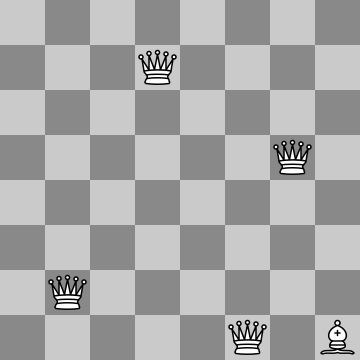

In [11]:
display_chessboard(((5, 9, 38, 51, 7)))

39


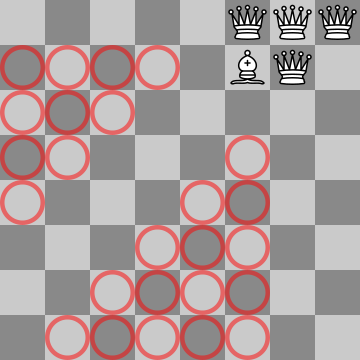

40


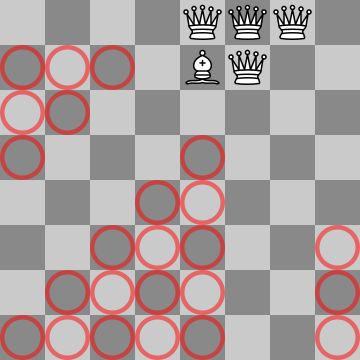

41


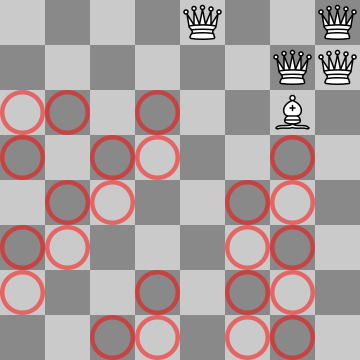

42


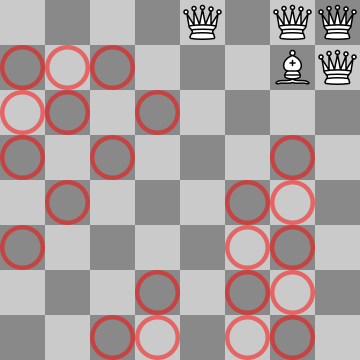

43


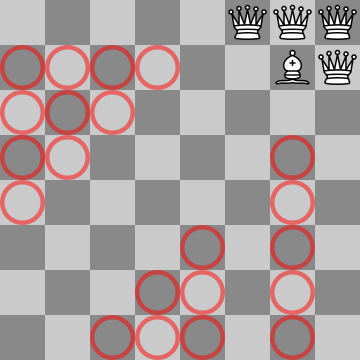

44


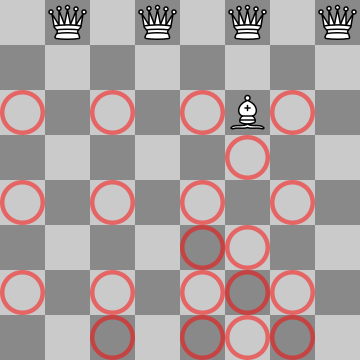

45


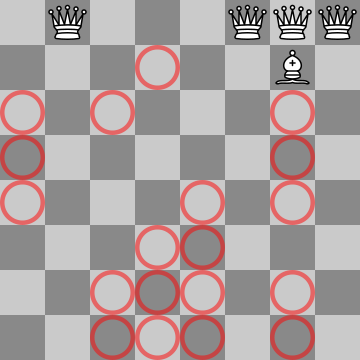

46


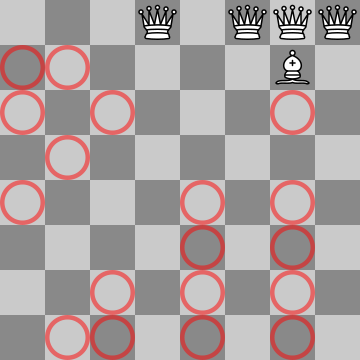

47


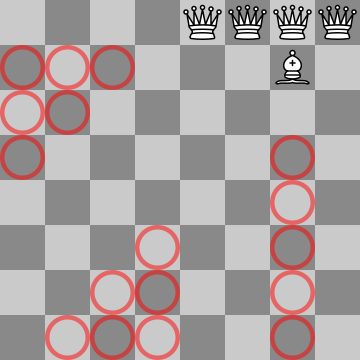

48


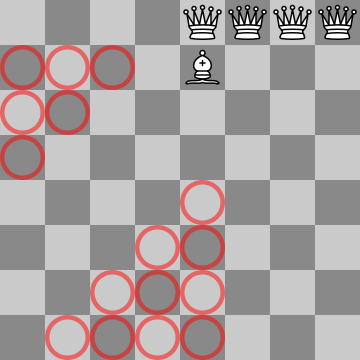

49


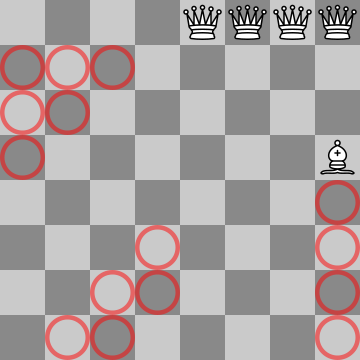

50


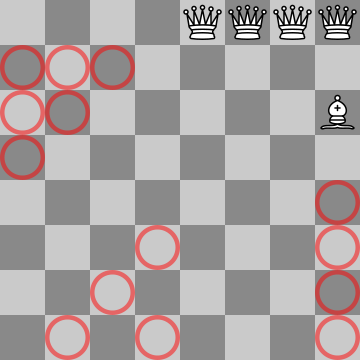

51


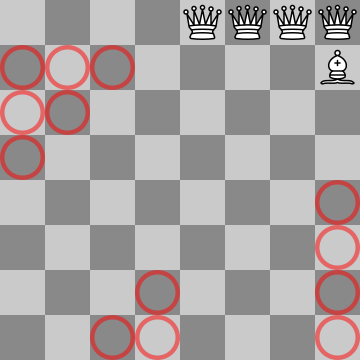

52


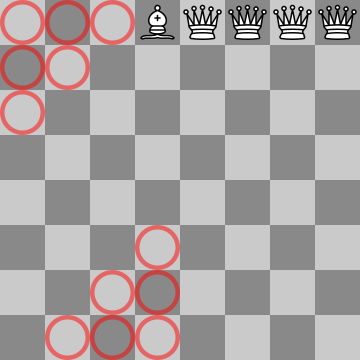

53


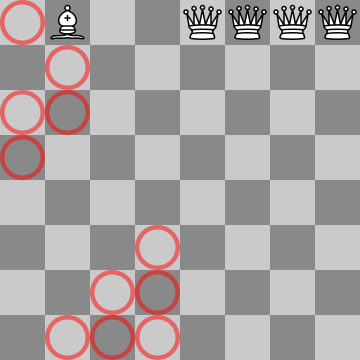

54


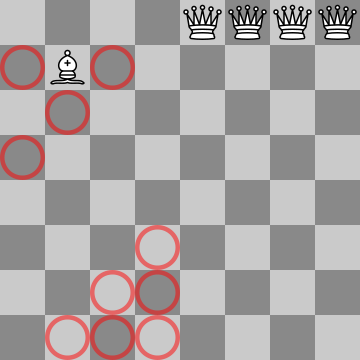

55


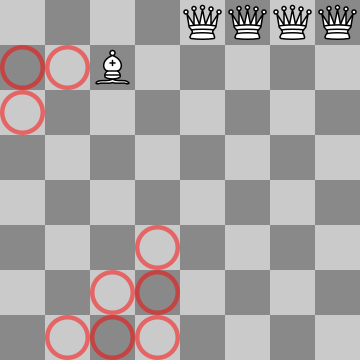

56


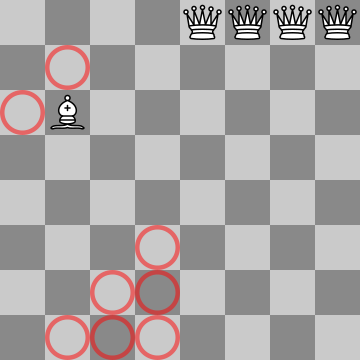

57


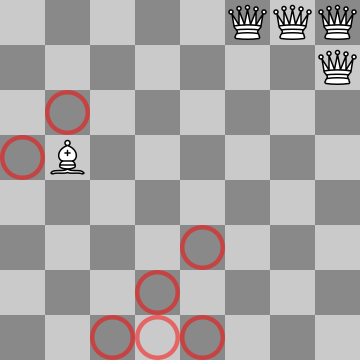

58


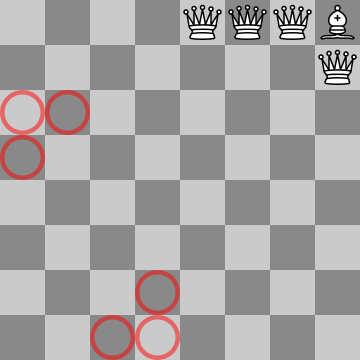

59


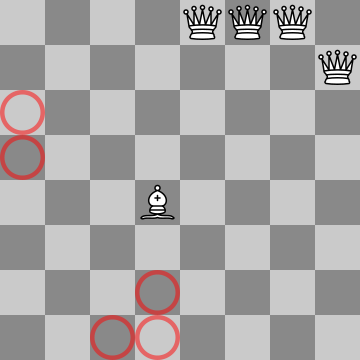

60


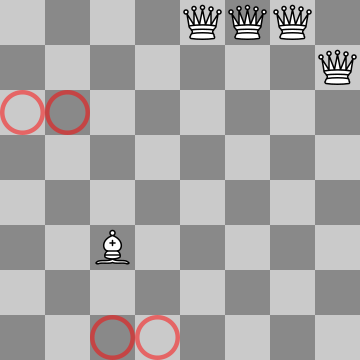

61


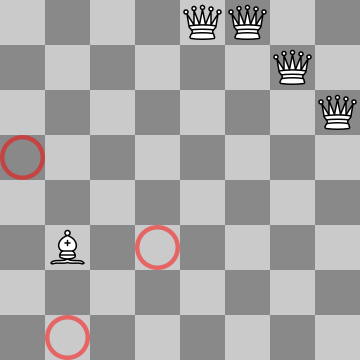

62


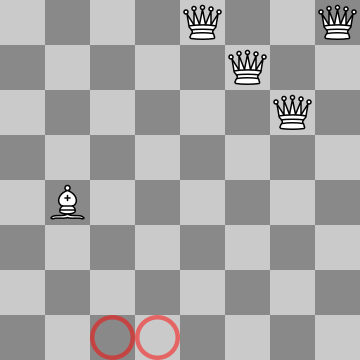

63


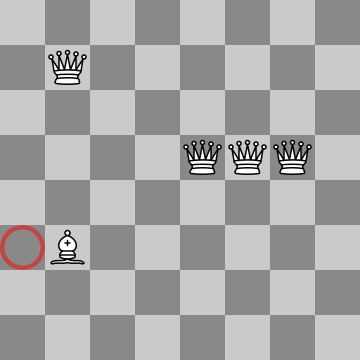

64


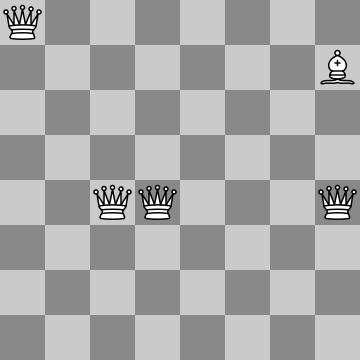

In [12]:

for k in sorted(recorded_solutions):
    print(k)
    display(SVG(display_chessboard(recorded_solutions[k][1])))
    with open('output/chess-try' + str(k) + '.svg', 'w') as f:
        f.write(display_chessboard(recorded_solutions[k][1]))

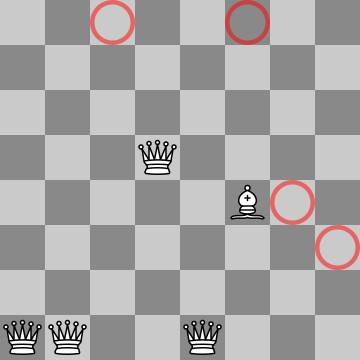

In [13]:
display_chessboard((0, 1, 4, 35, 29))

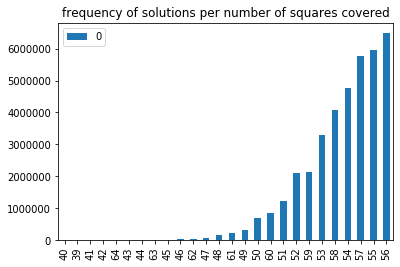

In [14]:
import pandas as pd 

pd.DataFrame(recorded_solutions).transpose().sort_values(by=0).plot(kind='bar', title="frequency of solutions per number of squares covered")

In [15]:
# inlined below
# @deprecated
def compute_allwinning_solutions():
    sols = []
    for cmb in gen_combinations():
        n = nbcases_covered_reuse(cmb)
        if (n == 64): # the solution(s)
            sols.append(cmb)
    return sols

# winning_sols = compute_allwinning_solutions()
# winning_sols

winning_sols = [cmb for cmb in gen_combinations() if nbcases_covered_reuse(cmb) == 64]
winning_sols

[(0, 6, 29, 51, 3),
 (0, 12, 39, 57, 24),
 (0, 12, 39, 57, 42),
 (0, 12, 39, 57, 51),
 (0, 12, 44, 52, 15),
 (0, 12, 44, 52, 22),
 (0, 12, 44, 52, 29),
 (0, 12, 44, 52, 36),
 (0, 12, 44, 52, 57),
 (0, 15, 33, 60, 3),
 (0, 15, 33, 60, 21),
 (0, 15, 33, 60, 30),
 (0, 15, 35, 44, 25),
 (0, 15, 35, 44, 61),
 (0, 20, 28, 60, 15),
 (0, 20, 28, 60, 36),
 (0, 20, 28, 60, 43),
 (0, 20, 28, 60, 50),
 (0, 20, 28, 60, 57),
 (0, 20, 38, 50, 25),
 (0, 20, 38, 50, 43),
 (0, 20, 38, 50, 61),
 (0, 22, 34, 52, 11),
 (0, 22, 34, 52, 29),
 (0, 22, 34, 52, 47),
 (0, 28, 37, 43, 17),
 (0, 28, 37, 43, 26),
 (0, 28, 37, 43, 53),
 (0, 28, 37, 43, 62),
 (0, 28, 37, 57, 11),
 (0, 28, 37, 57, 47),
 (0, 29, 35, 44, 10),
 (0, 29, 35, 44, 19),
 (0, 29, 35, 44, 46),
 (0, 29, 35, 44, 55),
 (0, 30, 43, 48, 24),
 (0, 33, 37, 38, 15),
 (0, 33, 37, 38, 36),
 (0, 33, 37, 38, 43),
 (0, 33, 37, 38, 50),
 (0, 33, 37, 38, 57),
 (0, 34, 35, 39, 15),
 (0, 34, 35, 39, 22),
 (0, 34, 35, 39, 29),
 (0, 34, 35, 39, 36),
 (0, 34, 35, 

In [16]:
nsol = 1
for sol in winning_sols:
    print(sol)
    # display(SVG(display_chessboard(sol)))
    with open('solutions/chess-solution' + str(nsol) + '.svg', 'w') as f:
        f.write(display_chessboard(sol))
    nsol = nsol + 1

(0, 6, 29, 51, 3)
(0, 12, 39, 57, 24)
(0, 12, 39, 57, 42)
(0, 12, 39, 57, 51)
(0, 12, 44, 52, 15)
(0, 12, 44, 52, 22)
(0, 12, 44, 52, 29)
(0, 12, 44, 52, 36)
(0, 12, 44, 52, 57)
(0, 15, 33, 60, 3)
(0, 15, 33, 60, 21)
(0, 15, 33, 60, 30)
(0, 15, 35, 44, 25)
(0, 15, 35, 44, 61)
(0, 20, 28, 60, 15)
(0, 20, 28, 60, 36)
(0, 20, 28, 60, 43)
(0, 20, 28, 60, 50)
(0, 20, 28, 60, 57)
(0, 20, 38, 50, 25)
(0, 20, 38, 50, 43)
(0, 20, 38, 50, 61)
(0, 22, 34, 52, 11)
(0, 22, 34, 52, 29)
(0, 22, 34, 52, 47)
(0, 28, 37, 43, 17)
(0, 28, 37, 43, 26)
(0, 28, 37, 43, 53)
(0, 28, 37, 43, 62)
(0, 28, 37, 57, 11)
(0, 28, 37, 57, 47)
(0, 29, 35, 44, 10)
(0, 29, 35, 44, 19)
(0, 29, 35, 44, 46)
(0, 29, 35, 44, 55)
(0, 30, 43, 48, 24)
(0, 33, 37, 38, 15)
(0, 33, 37, 38, 36)
(0, 33, 37, 38, 43)
(0, 33, 37, 38, 50)
(0, 33, 37, 38, 57)
(0, 34, 35, 39, 15)
(0, 34, 35, 39, 22)
(0, 34, 35, 39, 29)
(0, 34, 35, 39, 36)
(0, 34, 35, 39, 57)
(1, 7, 26, 52, 4)
(1, 8, 36, 45, 23)
(1, 8, 36, 45, 30)
(1, 8, 36, 45, 51)
(1, 8, 3

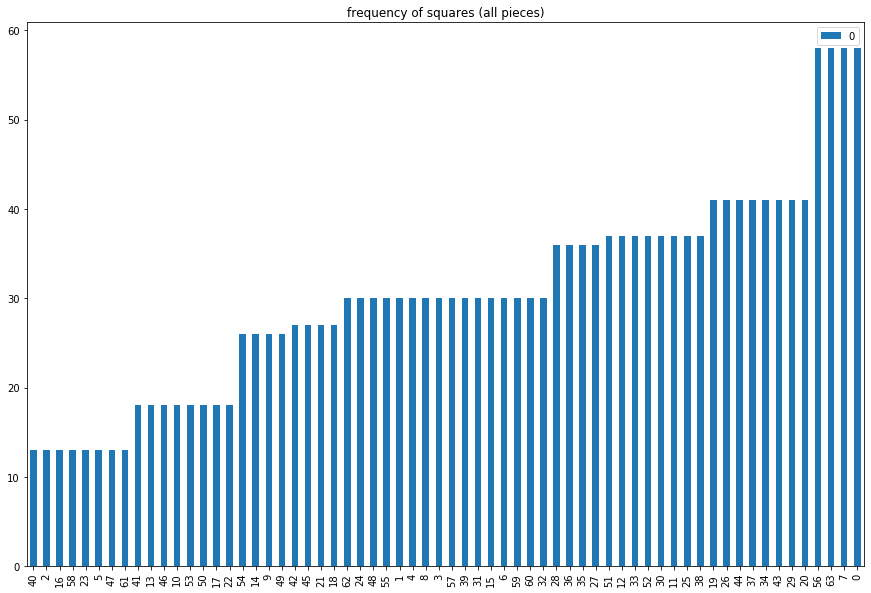

In [17]:
# nomber of cases that are frequently used (most effective)
# TODO: symmetrical solutions
from collections import defaultdict

appearances = defaultdict(int)

# flatten the list (all pieces confounded)
for curr in [item for sublist in winning_sols for item in sublist]:
    appearances[curr] += 1
appearances

pd.DataFrame(appearances, index=[0]).transpose().sort_values(by=0).plot(kind='bar', figsize=(15, 10), title="frequency of squares (all pieces)")

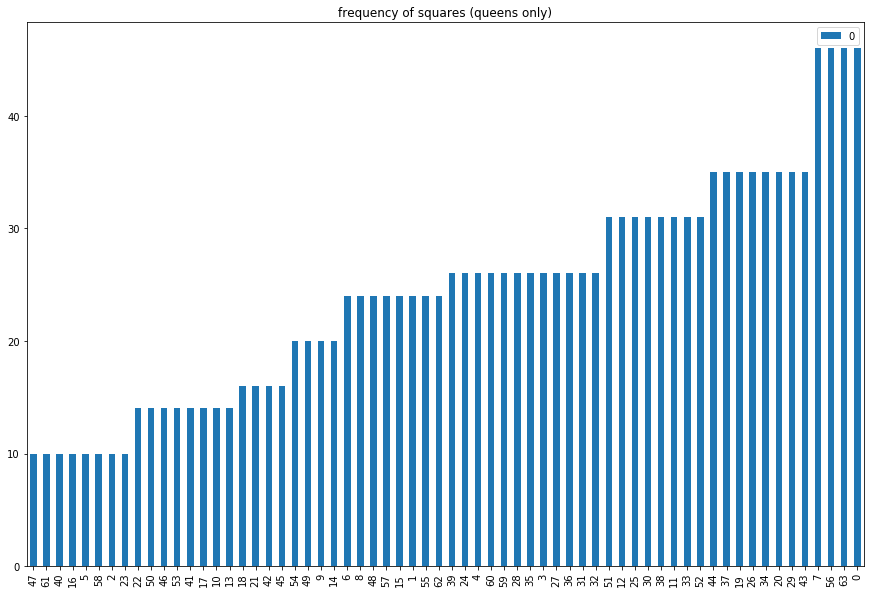

In [18]:
appearances = defaultdict(int)
# flatten the list (only queens)
for curr in [item for sublist in winning_sols for item in sublist[0:4]]:
    appearances[curr] += 1
appearances

pd.DataFrame(appearances, index=[0]).transpose().sort_values(by=0).plot(kind='bar', figsize=(15, 10), title="frequency of squares (queens only)")

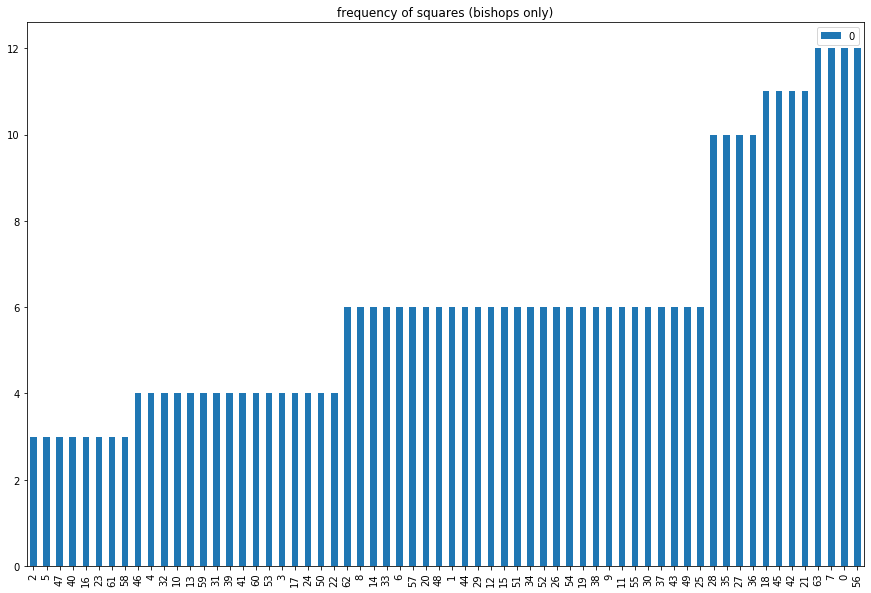

In [19]:
appearances = defaultdict(int)
# flatten the list (only bishops)
for curr in [item[4] for item in winning_sols]:
    appearances[curr] += 1
appearances

pd.DataFrame(appearances, index=[0]).transpose().sort_values(by=0).plot(kind='bar', figsize=(15, 10), title="frequency of squares (bishops only)")

In [20]:
queryable_solutions = pd.DataFrame(winning_sols).rename(axis=1, mapper={0: "queen0", 1: "queen1", 2: "queen2", 3: "queen3", 4: "bishop"})
# one of the queen is on "1" case
# make it easier to program and compose (like queen on A1 and A2)
def select_queen(q, sols):
    s = " | ".join(["queen" + str(i) + " == " + str(q) for i in range(0, 4)])
    return sols.query(s)
# one of the queen is on "1" case
queryable_solutions.query("queen0 == 1 | queen1 == 1 | queen2 == 1 | queen3 == 1")
select_queen(1, queryable_solutions) # same

# bishop in A1
queryable_solutions.query("bishop == 0") # kind of counterintuitive since the bishop controls almost nothing

# bishop in H8 (symmetric to A1)
queryable_solutions.query("bishop == 63")

# TODO: metamorpihic relations and symetric supressions

,queen0,queen1,queen2,queen3,bishop
55,1,13,32,44,63
74,2,14,33,52,63
79,2,22,32,52,63
110,4,8,37,41,63
117,4,16,38,50,63
253,11,30,49,61,63
258,11,31,41,61,63
264,12,16,38,49,63
291,13,25,47,59,63
303,14,25,47,51,63


In [21]:
select_queen(29, select_queen(28, queryable_solutions)) # two queens together
 

,queen0,queen1,queen2,queen3,bishop
368,24,28,29,63,6
369,24,28,29,63,27
370,24,28,29,63,34
371,24,28,29,63,41
372,24,28,29,63,48


In [22]:
queryable_solutions.query("bishop == 28") # at the center

,queen0,queen1,queen2,queen3,bishop
83,3,15,34,46,28
94,3,23,33,53,28
130,4,36,44,56,28
133,5,9,38,51,28
139,5,17,39,51,28
148,6,10,39,43,28
244,11,23,33,54,28
266,12,20,52,56,28
381,25,29,30,56,28
384,26,27,31,56,28


In [36]:
len(select_queen(32, queryable_solutions)), len(select_queen(24, queryable_solutions))
len(select_queen(33, queryable_solutions)), len(select_queen(25, queryable_solutions))

(31, 31)

In [23]:
def find_onesolution():
    for cmb in gen_combinations():
        n = nbcases_covered_reuse(cmb)
        if (n == 64):
            return cmb

print(find_onesolution())

(0, 6, 29, 51, 3)


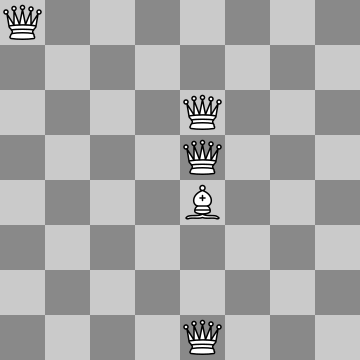

In [24]:
import numpy as np
import random

# quite brutal since we can have 0, 0, 0, 0, 0 tries 
# also, we can use some properties of the problem and explore the first 32 squares of the queen (coz then it's symmetric)
def rand_combinations():
    return (random.randrange(0, 32), random.randrange(0, 64), random.randrange(0, 64), random.randrange(0, 64), random.randrange(0, 64))


def find_onesolution_brutal():
    while(True):
        cmb = rand_combinations()
        if (nbcases_covered_reuse(cmb) == 64):
            return cmb
    return None

display_chessboard(find_onesolution_brutal())



In [25]:
# https://stackoverflow.com/questions/22229796/choose-at-random-from-combinations
from itertools import combinations, permutations
import random 
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

# does not scale 
# random_combination(permutations(range(0, 64), 5), 1)
# budget = 10000
# random_combination(combinations(range(0, 64), 5), budget)

(35, 44, 0, 29, 46)


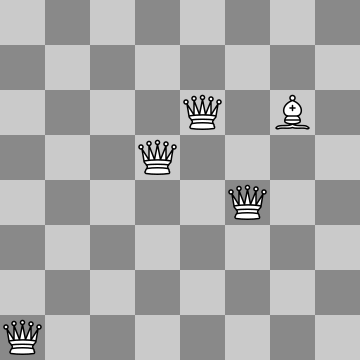

In [79]:
######### 280 characters solution?
# chess.QUEEN = 5
# chess.BISHOP = 3
# https://python-chess.readthedocs.io/en/latest/core.html#piece-types
# we reuse built-in facilities of python-chess for generating moves
import chess,random
def n(c):
    b=chess.Board() 
    b.clear_board()    
    for q in range(0, 4):
        b.set_piece_at(c[q], chess.Piece(5,color=True)) 
    b.set_piece_at(c[4], chess.Piece(3,color=True)) 
    s = [list(b.attacks(c[q])) for q in range(0, 5)]
    return len(set().union(*s, list(c)))
def g():
    return random.randrange(0,64)
def r():
    return (g(),g(),g(),g(),g()) #     return [g() for i in range(0,5)]
while(True):
    c = r()
    if (n(c) == 64):
        print(c)
        break
display_chessboard(c)

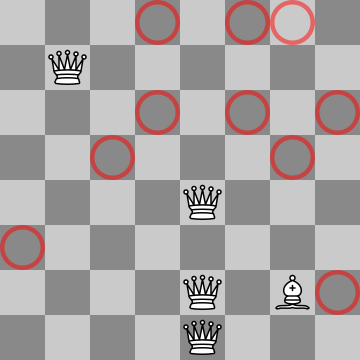

In [84]:
display_chessboard((28, 49, 4, 12, 14))

In [101]:
# 6x6 board
l = list(filter(lambda x: (x >> 3) < 6 and (x & 7) < 6, range(0, 64)))
assert(len(l) == 36)
assert(max(l) == 45)
l

[0,
 1,
 2,
 3,
 4,
 5,
 8,
 9,
 10,
 11,
 12,
 13,
 16,
 17,
 18,
 19,
 20,
 21,
 24,
 25,
 26,
 27,
 28,
 29,
 32,
 33,
 34,
 35,
 36,
 37,
 40,
 41,
 42,
 43,
 44,
 45]

In [135]:
import numpy as np

# experiments with weighted sampling
# weights = [1/64 for c in range(0, 64)]
weights = [1/128 for c in range(0, 64)]
for i in filter(lambda x: x >> 3 == 3,range(0,64)): # square in the centers are more probable
    weights[i] = 1/16 + 1/128 # 1/2 in total (8/16)
print(np.sum(weights))
n = 0
s = []
nRepeat=100000
while (n < nRepeat):
    n = n + 1
    s.append(np.random.choice(range(0, 64),
                           p=weights, 
                           size=(3,)))
c = 0
for a in s:
    if (24 in a):
        c = c + 1

(c / nRepeat) * 100

1.0


19.553